In [1]:
# Load model directly
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(17)

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small", use_fast=True, 
                                          add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained("prajjwal1/bert-small", return_dict_in_generate=True, 
                                             pad_token_id=tokenizer.eos_token_id).to(device)

e:\Downloads\Programs\conda\envs\GuidedNeuralChecker\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [2]:
import sys
print(sys.path.append(".."))

None


In [3]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
from pythautomata.base_types.symbol import SymbolStr

property_model = get_man_woman_wfa(SymbolStr(tokenizer.sep_token))

In [4]:
from case_studies.bert_small.bert_small_probabilistic_model_wrapper import BERT_SMALL_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet

wrapper = BERT_SMALL_probabilistic_model_wrapper(alphabet, device, model, tokenizer, property_model)

In [5]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.utilities.sequence_generator import SequenceGenerator
import numpy as np


class GuidedSequenceGenerator(SequenceGenerator):    
    def __init__(self, guide, max_seq_length: int, random_seed: int = 21):
        self.guide = guide
        super().__init__(guide.alphabet, max_seq_length, random_seed)
    
    def generate_words(self, number_of_words: int):
        return [self.generate_single_word(0) for _ in range(number_of_words)]

    def generate_single_word(self, length):
        word = Sequence()
        first_state = list(filter(lambda x: x.initial_weight ==
                        1, self.guide.weighted_states))[0]
        symbols, weights, next_states = first_state.get_all_symbol_weights()
        next_symbol = np.random.choice(symbols, p=weights)
        while next_symbol != self.guide.terminal_symbol:
            word += next_symbol
            i = symbols.index(next_symbol)
            next_state = next_states[i]
            symbols, weights, next_states = next_state.get_all_symbol_weights()
            weights = np.array(weights)
            weights = weights / sum(weights)
            next_symbol = np.random.choice(symbols, p=weights)
        return word


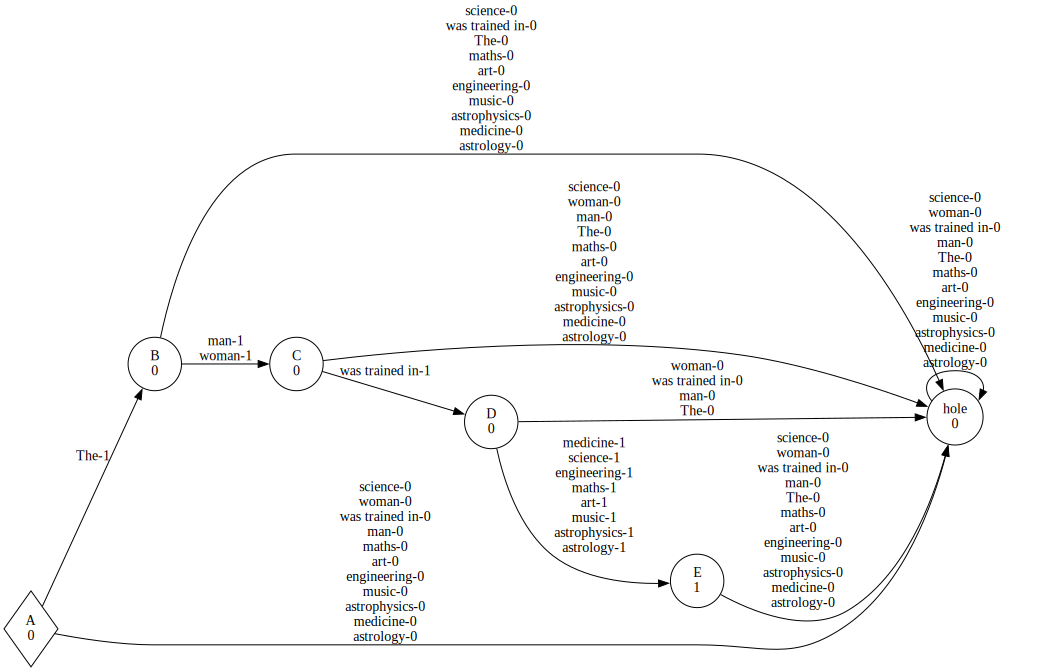

In [6]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(property_model)

display(graph)

In [7]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
synchronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_BERT_SMALL", max_seq_length=10)

In [8]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator

partitioner = QuantizationProbabilityPartitioner(100)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = GuidedSequenceGenerator(property_model, max_seq_length=10)
max_states = 10
max_query_length = 10


In [9]:
teacher  = PACProbabilisticTeacher(synchronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=sequence_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [10]:
learning_result = learner.learn(teacher, verbose=True)

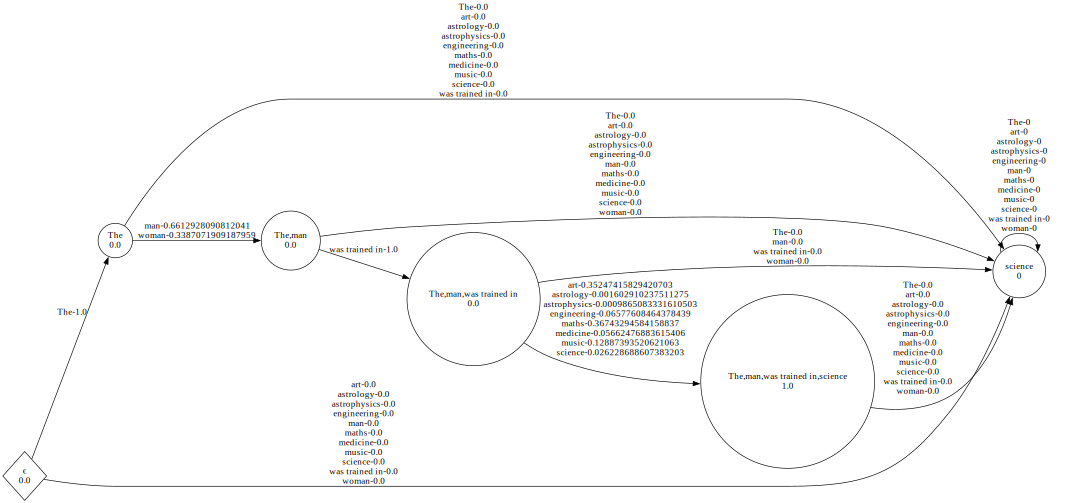

In [11]:
graph = exporter.create_graph(learning_result.model)

display(graph)